In [84]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import erf
from scipy.integrate import quad
from scipy.fft import dst
import math
import networkx as nx

from utils import *
from intersection_graph import *

# plt.rc('text', usetex=False)

# Activation Functions

# Tanh

In [86]:
M = m_matrix(5)
Q, labels = q_matrix(5)
D = d_matrix(5)

byL = indices_by_rep(labels)


blocks = {}
for Ls in byL:
    for Lk in byL:
        B = activation_func_block(Q, D, byL, Ls, Lk, activation_func=TANH)
        if not is_zero_numeric(B, tol=1e-4):
            blocks[(Ls, Lk)] = B
        else:
            blocks[(Ls, Lk)] = sp.Matrix.zeros(1, 1)


i = 0
print(f"{list(blocks.keys())[i][0]} -> {list(blocks.keys())[i][1]}")
blocks[list(blocks.keys())[i]]

L_0 -> L_0


Matrix([[0.761594155955765]])

In [87]:
Ls = "L_0"
Lk = "L_2"

activation_func_block(Q, D, byL, Ls, Lk, activation_func=TANH)

Matrix([
[0],
[0]])

$\text{Example}: C_n$

/Users/manishaya/Desktop/Masters/Masters/equivarient_NN/intersection_graph.py:134: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


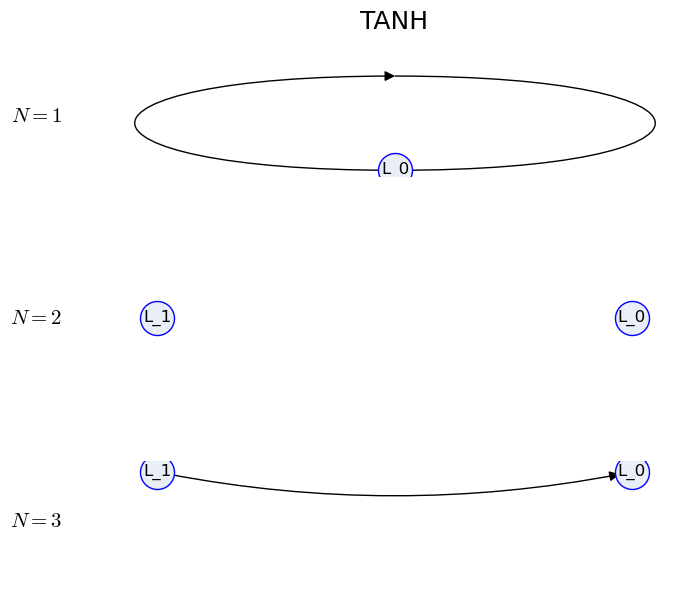

In [88]:
N = 3
# activ_funcs = [LINEAR, RELU, ABS, GELU, BINARY, SIGMOID, TANH, SOFTSIGN, SOFTPLUS, LEAKY_RELU, SILU, ELISH, GAUSSIAN, SINUSOIDAL]
activ_funcs = [TANH]

fig, axs = plt.subplots(N, len(activ_funcs),
                        figsize=(7*len(activ_funcs), 2*N),
                        constrained_layout=True)

# --- make axs always 2D ---
axs = np.atleast_2d(axs)
if axs.shape[0] == 1 and N > 1:      # single row
    axs = axs.T
# now axs[i, j] always works

for j, activ_func in enumerate(activ_funcs):
    for i, n in enumerate(range(1, N+1)):
        Q, labels = q_matrix(n)
        M = m_matrix(n)
        D = d_matrix(n)
        byL = indices_by_rep(labels)

        blocks = {}
        for Ls in byL:
            for Lk in byL:
                B = activation_func_block(Q, D, byL, Ls, Lk, activation_func=activ_func)
                if not is_zero_numeric(B, tol=1e-4):
                    blocks[(Ls, Lk)] = B

        ax = axs[i, j]
        intersection_graph(
            blocks,
            use_latex=False,
            title=None,
            layout="auto",
            ax=ax
        )

        ax.set_xticks([])
        ax.set_yticks([])
        for side in ("top", "right", "bottom", "left"):
            ax.spines[side].set_visible(False)

        if j == 0:
            ax.text(-0.08, 0.5, rf"$N={n}$", transform=ax.transAxes,
                    ha="right", va="center", fontsize=15)

        if i == 0:
            ax.set_title(f"{activ_func.__name__}", fontsize=18, pad=20)

plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

In [89]:
def calculate_block(N, activ_func):
    Q, labels = q_matrix(N)
    D = d_matrix(N)
    byL = indices_by_rep(labels)

    blocks = {}
    for Ls in byL:
        for Lk in byL:
            B = activation_func_block(Q, D, byL, Ls, Lk, activation_func=activ_func)
            if not is_zero_numeric(B, tol=1e-4):
                blocks[(Ls, Lk)] = B
    
    return blocks


def plot_intersection_graph(N, activ_func):

    blocks = calculate_block(N, activ_func)

    fig, ax = plt.subplots(1, 1, figsize=(8,6), constrained_layout=True)

    intersection_graph(
                blocks,
                use_latex=False,
                title=None,
                layout="auto",
                ax=ax
            )
    
    if activ_func.__name__.find("lambda") == -1:
        plt.suptitle(f"{activ_func.__name__}" + rf"$\quad N={N}$", fontsize=18, y=1.02)
    else:
        plt.suptitle(f"Custom Function" + rf"$\quad N={N}$", fontsize=18, y=1.02)
    
    plt.show()


def fourier_series(x, a_coeffs, b_coeffs=None):

    x = np.atleast_1d(x)
    X = x[None, :]                     # shape (1, Npoints)
    result = 0.5 * a_coeffs[0]          # constant term

    if len(a_coeffs) > 1:
        n = np.arange(1, len(a_coeffs))
        result += np.sum(a_coeffs[1:, None] * np.cos(n[:, None] * X), axis=0)

    if b_coeffs is not None and len(b_coeffs) > 0:
        n = np.arange(1, len(b_coeffs)+1)
        result += np.sum(b_coeffs[:, None] * np.sin(n[:, None] * X), axis=0)

    return result

## Fourier ReLU & Tanh

In [90]:
M = 2000
L = np.pi
x = np.linspace(-L, L, 10000)
m = np.arange(1, M+1)[:, None]        # shape (M,1) for broadcasting


# ====================================================
# ReLU Fourier 
# ====================================================

a0 = np.pi/2
a_rest = ((-1)**m.flatten() - 1) / (np.pi * m.flatten()**2)
a = np.concatenate([[a0], a_rest])
b = -(-1)**m.flatten() / m.flatten()

relu_fourier = lambda X: fourier_series(X, a, b)

# ====================================================
# tanh Fourier
# ====================================================

Ng = 4096
t = np.linspace(0, np.pi, Ng+2, endpoint=True)[1:-1]  # remove 0 and π
f = np.tanh(t)

# DST-I gives coefficients proportional to ∫ f(t) sin(mt) dt
bk = dst(f, type=1)                # length Ng
# Scale to continuous normalisation b_m = (2/π) ∫_0^π f sin(m t) dt
d_full = 2/(Ng+1) * bk             # this matches the sine series on that grid
d = d_full[:M]                     # take the first M coefficients
c = np.zeros(M+1)

tanh_fourier = lambda X: fourier_series(X, c, d)


# ---

aa = np.random.random(32)
bb = np.random.random(32)

random_fourier = lambda X: fourier_series(X, aa, bb)

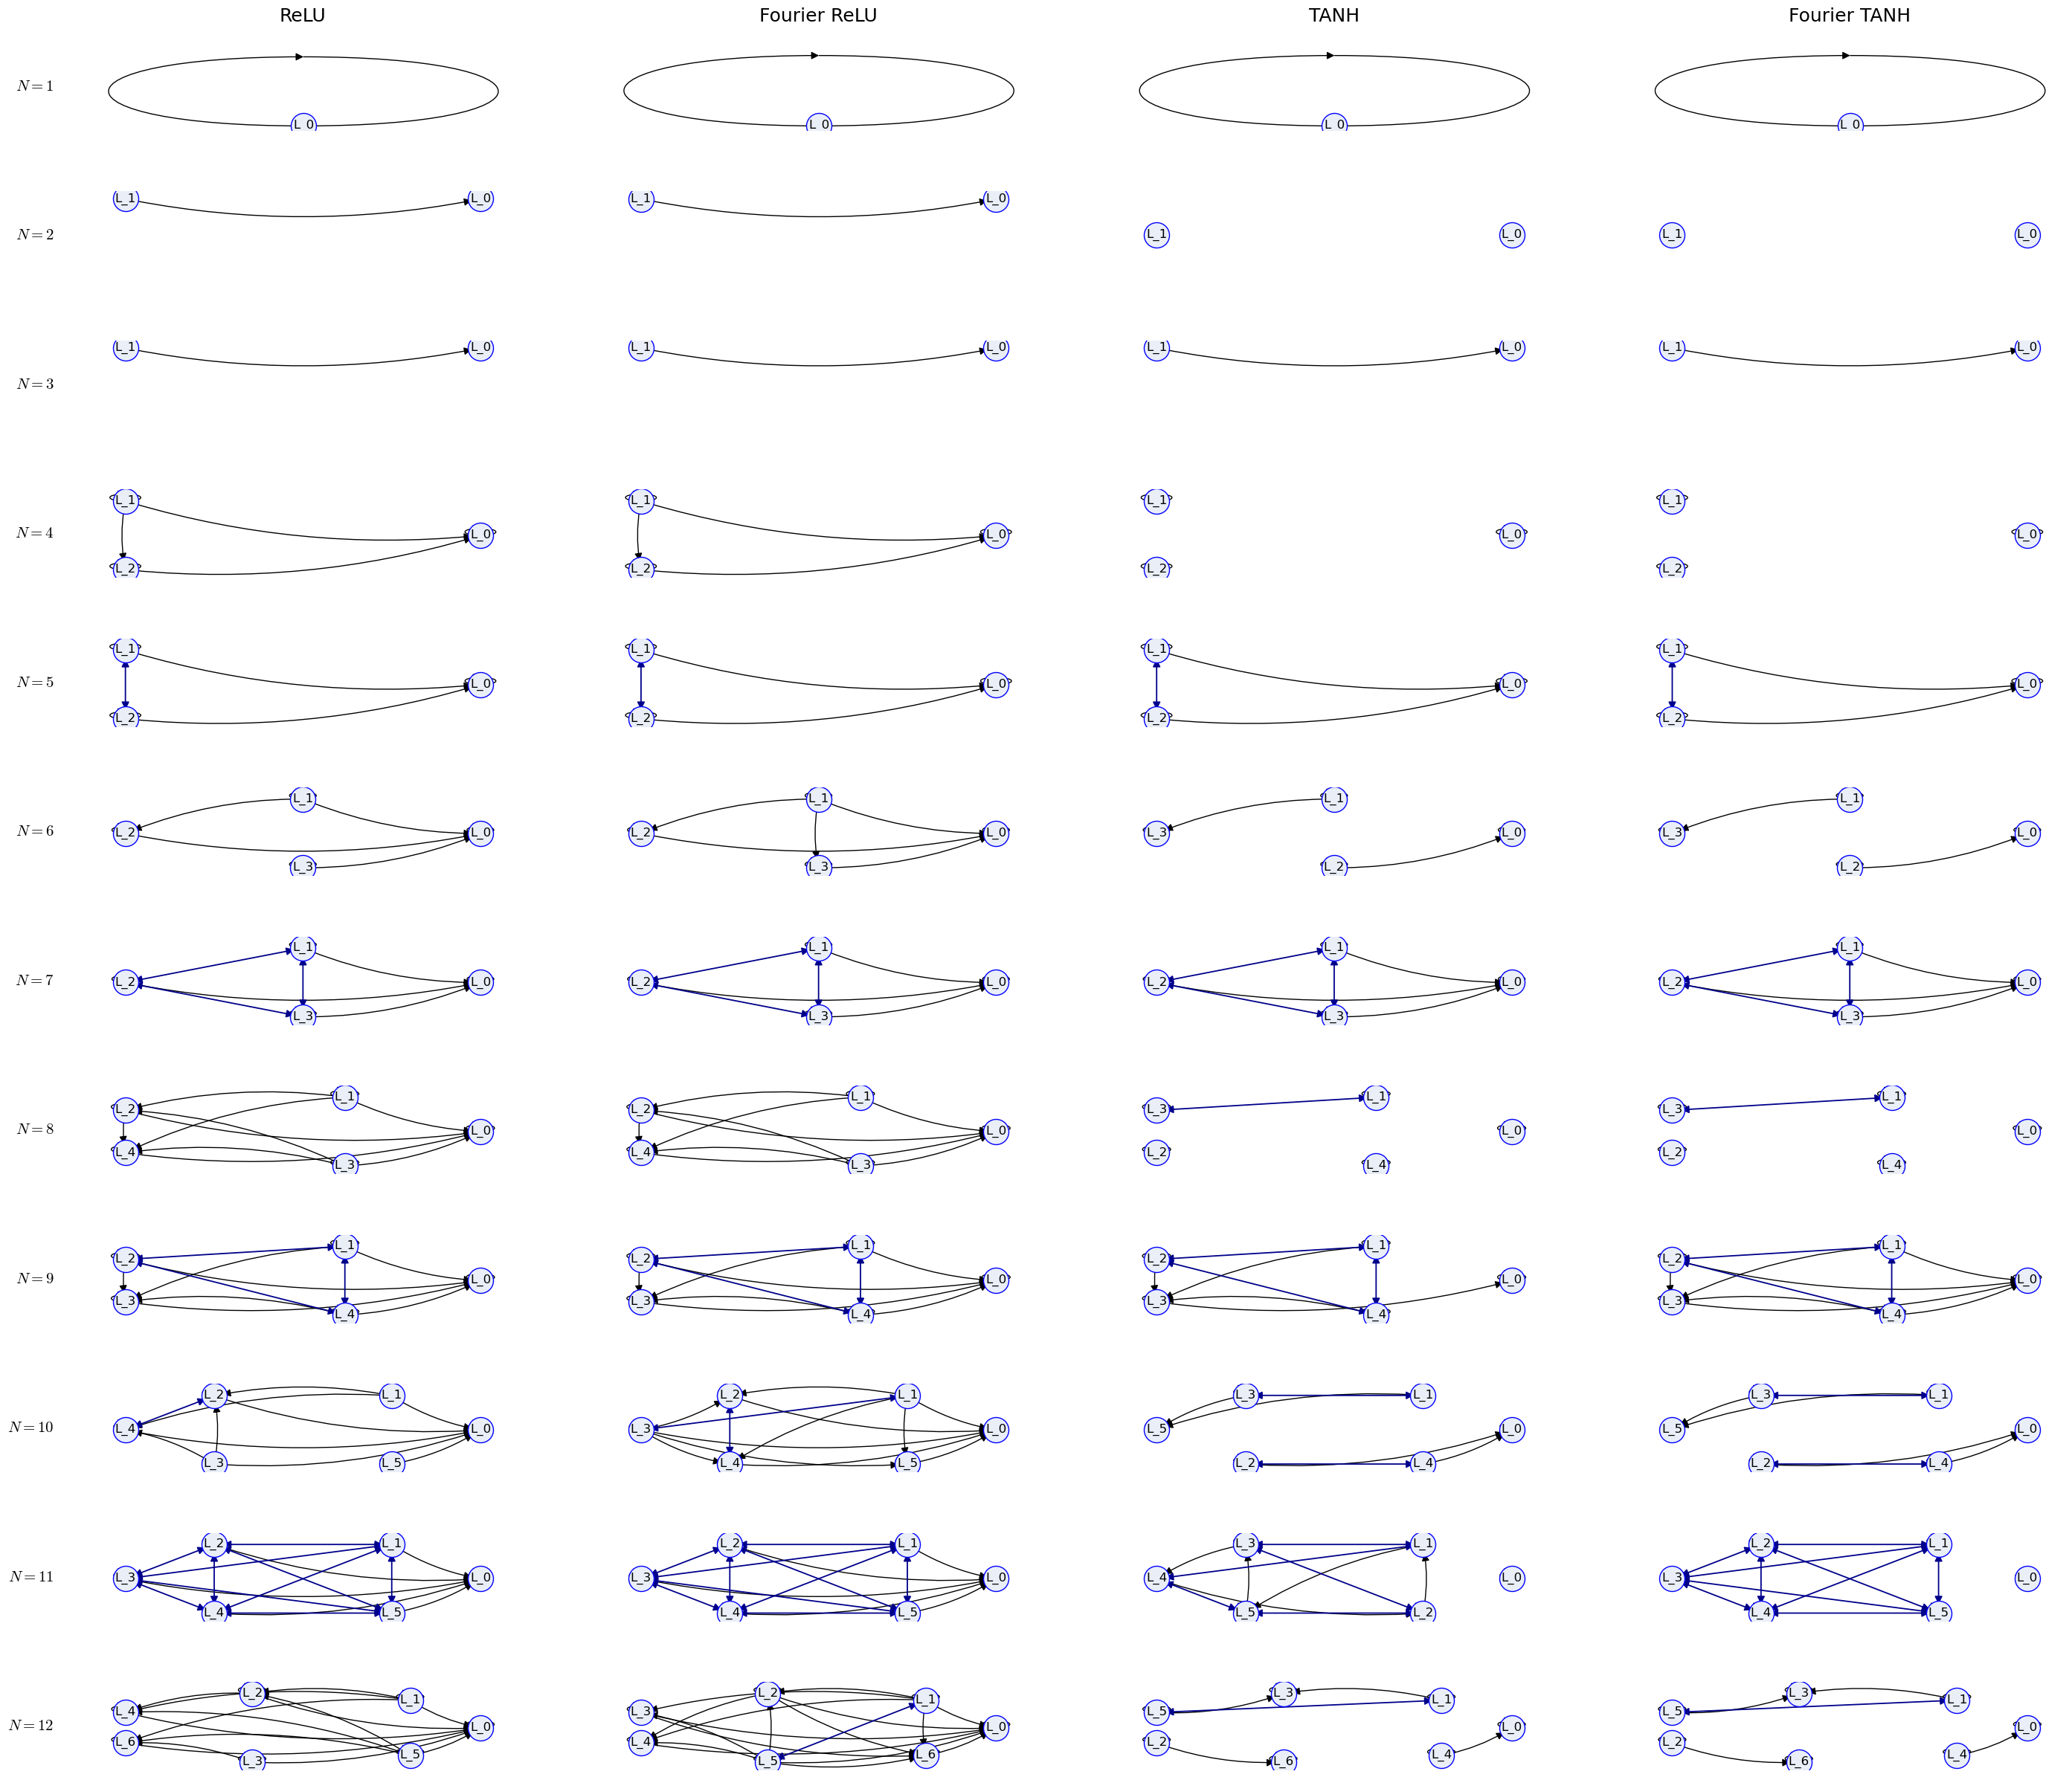

In [91]:
N = 12
# activ_funcs = [LINEAR, RELU, ABS, GELU, BINARY, SIGMOID, TANH, SOFTSIGN, SOFTPLUS, LEAKY_RELU, SILU, ELISH, GAUSSIAN, SINUSOIDAL]
activ_funcs = [RELU, relu_fourier, TANH, tanh_fourier]
titles = ["ReLU", "Fourier ReLU", "TANH", "Fourier TANH"]

fig, axs = plt.subplots(N, len(activ_funcs),
                        figsize=(7*len(activ_funcs), 2*N),
                        constrained_layout=True)

# --- make axs always 2D ---
axs = np.atleast_2d(axs)
if axs.shape[0] == 1 and N > 1:      # single row
    axs = axs.T
# now axs[i, j] always works

for j, activ_func in enumerate(activ_funcs):
    for i, n in enumerate(range(1, N+1)):
        Q, labels = q_matrix(n)
        M = m_matrix(n)
        D = d_matrix(n)
        byL = indices_by_rep(labels)

        blocks = {}
        for Ls in byL:
            for Lk in byL:
                B = activation_func_block(Q, D, byL, Ls, Lk, activation_func=activ_func)
                if not is_zero_numeric(B, tol=1e-4):
                    blocks[(Ls, Lk)] = B

        ax = axs[i, j]
        intersection_graph(
            blocks,
            use_latex=False,
            title=None,
            layout="auto",
            ax=ax
        )

        ax.set_xticks([])
        ax.set_yticks([])
        for side in ("top", "right", "bottom", "left"):
            ax.spines[side].set_visible(False)

        if j == 0:
            ax.text(-0.08, 0.5, rf"$N={n}$", transform=ax.transAxes,
                    ha="right", va="center", fontsize=15)

        if titles is None:
            if i == 0:
                ax.set_title(f"{activ_func.__name__}", fontsize=18, pad=20)
        
        else:
            if i == 0:
                ax.set_title(titles[j], fontsize=18, pad=20)

plt.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

In [ ]:
for n in range(1, 16):
    print(f"N={n}, gelu, tanh_fourier = {len(set(calculate_block(n, GELU).keys()) - set(calculate_block(n, tanh_fourier).keys()))}")


N=1, gelu, tanh_fourier = 0
N=2, gelu, tanh_fourier = 1
N=3, gelu, tanh_fourier = 0
N=4, gelu, tanh_fourier = 3
N=5, gelu, tanh_fourier = 0
N=6, gelu, tanh_fourier = 3
N=7, gelu, tanh_fourier = 0
N=8, gelu, tanh_fourier = 9
N=9, gelu, tanh_fourier = 0
N=10, gelu, tanh_fourier = 7
N=11, gelu, tanh_fourier = 5
N=12, gelu, tanh_fourier = 13
N=13, gelu, tanh_fourier = 6
N=14, gelu, tanh_fourier = 13
N=15, gelu, tanh_fourier = 16


In [106]:
for n in range(1, 16):
    print(f"N={n}, tanh_fourier, gelu = {len(set(calculate_block(n, tanh_fourier).keys()) - set(calculate_block(n, GELU).keys()))}")

N=1, tanh_fourier, gelu = 0
N=2, tanh_fourier, gelu = 0
N=3, tanh_fourier, gelu = 0
N=4, tanh_fourier, gelu = 0
N=5, tanh_fourier, gelu = 0
N=6, tanh_fourier, gelu = 1
N=7, tanh_fourier, gelu = 0
N=8, tanh_fourier, gelu = 2
N=9, tanh_fourier, gelu = 0
N=10, tanh_fourier, gelu = 4
N=11, tanh_fourier, gelu = 5
N=12, tanh_fourier, gelu = 5
N=13, tanh_fourier, gelu = 12
N=14, tanh_fourier, gelu = 9
N=15, tanh_fourier, gelu = 12


In [107]:
for n in range(1, 16):
    print(f"N={n}, relu, gelu = {len(set(calculate_block(n, RELU).keys()) - set(calculate_block(n, GELU).keys()))}")

N=1, relu, gelu = 0
N=2, relu, gelu = 0
N=3, relu, gelu = 0
N=4, relu, gelu = 0
N=5, relu, gelu = 0
N=6, relu, gelu = 0
N=7, relu, gelu = 0
N=8, relu, gelu = 0
N=9, relu, gelu = 0
N=10, relu, gelu = 0
N=11, relu, gelu = 5
N=12, relu, gelu = 0
N=13, relu, gelu = 12
N=14, relu, gelu = 0
N=15, relu, gelu = 12


In [108]:
for n in range(1, 16):
    print(f"N={n}, gelu, relu = {len(set(calculate_block(n, GELU).keys()) - set(calculate_block(n, RELU).keys()))}")

N=1, gelu, relu = 0
N=2, gelu, relu = 0
N=3, gelu, relu = 0
N=4, gelu, relu = 0
N=5, gelu, relu = 0
N=6, gelu, relu = 0
N=7, gelu, relu = 0
N=8, gelu, relu = 0
N=9, gelu, relu = 0
N=10, gelu, relu = 0
N=11, gelu, relu = 0
N=12, gelu, relu = 0
N=13, gelu, relu = 0
N=14, gelu, relu = 0
N=15, gelu, relu = 0
